In [1]:
import numpy as np, basic, cosmology, local, tools_multitracer as mass, plottools as pl
from matplotlib.pyplot import *

In [2]:
lmax = 2048
euc_zbin = 5
lss_zbin = 5

In [3]:
frac = mass.galaxy_distribution(np.linspace(0,50,1000),zbn={'euc':euc_zbin,'lss':lss_zbin})[3]

In [4]:
l, camb_cls = mass.read_camb_cls(add_euc=euc_zbin,add_lss=lss_zbin)

In [5]:
# for cross spectrum
vecs = {}
ocov = {}
Scov = mass.get_covariance_signal(lmax,add_cmb=['klb'],add_euc=euc_zbin,add_lss=lss_zbin)
print(np.shape(Scov))

(12, 12, 2049)


In [6]:
# CIB covariance
scib = mass.get_covariance_signal(lmax,add_cmb=[],add_euc=0,add_lss=0)
ncib = mass.get_covariance_noise(lmax,add_cmb=[],add_euc=0,add_lss=0)
vecs['cib'] = Scov[0,1:2,:]
ocov['cib'] = scib + ncib

In [7]:
# Euclid covariance
seuc = mass.get_covariance_signal(lmax,add_cmb=[],add_cib=False,add_euc=euc_zbin,add_lss=0)
neuc = mass.get_covariance_noise(lmax,frac=frac,add_cmb=[],add_cib=False,add_euc=euc_zbin,add_lss=0)
vecs['euc'] = Scov[0,2:2+euc_zbin,:]
ocov['euc'] = seuc + neuc

In [8]:
# LSST covariance
slss = mass.get_covariance_signal(lmax,add_cmb=[],add_cib=False,add_euc=0,add_lss=lss_zbin)
nlss = mass.get_covariance_noise(lmax,frac=frac,add_cmb=[],add_cib=False,add_euc=0,add_lss=lss_zbin)
vecs['lss'] = Scov[0,2+euc_zbin:2+euc_zbin+lss_zbin,:]
ocov['lss'] = slss + nlss

In [9]:
# gal covariance
sgal = mass.get_covariance_signal(lmax,add_cmb=[],add_cib=False,add_euc=euc_zbin,add_lss=lss_zbin)
ngal = mass.get_covariance_noise(lmax,frac=frac,add_cmb=[],add_cib=False,add_euc=euc_zbin,add_lss=lss_zbin)
vecs['gal'] = Scov[0,2:2+euc_zbin+lss_zbin,:]
ocov['gal'] = sgal + ngal

In [10]:
# cib+gal covariance
sext = mass.get_covariance_signal(lmax,add_cmb=[],add_euc=euc_zbin,add_lss=lss_zbin)
next = mass.get_covariance_noise(lmax,frac=frac,add_cmb=[],add_euc=euc_zbin,add_lss=lss_zbin)
vecs['ext'] = Scov[0,1:2+euc_zbin+lss_zbin,:]
ocov['ext'] = sext + next

In [11]:
icov = {}
rho  = {}
for t in ['cib','euc','lss','gal','ext']:
    icov[t] = ocov[t].copy()
    icov[t][:,:,1:] = np.array( [ np.linalg.inv(ocov[t][:,:,l]) for l in range(1,lmax+1) ] ).T
    rho[t] = np.array( [ np.dot( vecs[t][:,l], np.dot( icov[t][:,:,l], vecs[t][:,l] ) ) for l in range(lmax+1) ] ) / ( camb_cls['klbklb'][:lmax+1] + 1e-30 )

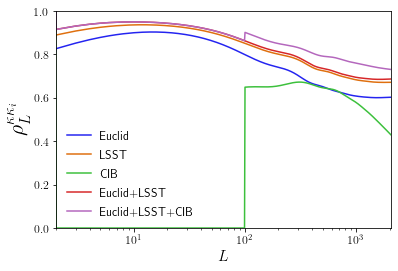

In [20]:
pl.plot_1dstyle(usetex=True,xmin=2,xmax=lmax,ymin=0,ymax=1,xlab=r'$L$',ylab=r'$\rho^{\kappa\kappa_i}_L$',ylabsize=22,xlog=True)
for t, label in [('euc','Euclid'),('lss','LSST'),('cib','CIB'),('gal','Euclid+LSST'),('ext','Euclid+LSST+CIB')]:
    plot(l, np.sqrt(rho[t]),label=label)
legend()
savefig('fig_rho.pdf')